# F1 Singapore GP Feature Engineering

This notebook creates predictive features for the Singapore GP winner prediction model:

## Feature Categories:
1. **Driver Performance Features**
   - Singapore GP history and success rate
   - Recent form (last 5 races)
   - Career statistics and consistency
   - Age and experience factors

2. **Team/Constructor Features**
   - Singapore GP team performance
   - Recent team form and reliability
   - Car performance characteristics
   - Team championship standings

3. **Track-Specific Features**
   - Singapore circuit characteristics
   - Sector performance analysis
   - Overtaking difficulty
   - Tire degradation patterns

4. **Weather Features**
   - Historical weather impact
   - Temperature and humidity effects
   - Rain probability and impact
   - Weather-related performance patterns

5. **Temporal Features**
   - Season progression
   - Championship pressure
   - Time of day effects
   - Historical trends


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

warnings.filterwarnings('ignore')

# Set up paths
data_dir = Path('../data')
output_dir = Path('../data/features')
output_dir.mkdir(exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Feature engineering setup complete!")
print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")


Feature engineering setup complete!
Data directory: ..\data
Output directory: ..\data\features


## 1. Load and Explore Data


In [2]:
# Load the collected data
singapore_results = pd.read_csv(data_dir / 'singapore_gp_results_2008_2024.csv')
weather_data = pd.read_csv(data_dir / 'singapore_weather_2008_2024.csv')

print("=== DATA OVERVIEW ===")
print(f"Singapore GP Results: {len(singapore_results)} records")
print(f"Weather Data: {len(weather_data)} records")

print("\n=== SINGAPORE GP RESULTS COLUMNS ===")
print(singapore_results.columns.tolist())

print("\n=== WEATHER DATA COLUMNS ===")
print(weather_data.columns.tolist())

print("\n=== SINGAPORE GP RESULTS SAMPLE ===")
print(singapore_results.head())

print("\n=== WEATHER DATA SAMPLE ===")
print(weather_data.head())


=== DATA OVERVIEW ===
Singapore GP Results: 358 records
Weather Data: 17 records

=== SINGAPORE GP RESULTS COLUMNS ===
['Year', 'Race', 'Date', 'Abbreviation', 'FullName', 'TeamName', 'Position', 'Points', 'GridPosition', 'Status', 'Time']

=== WEATHER DATA COLUMNS ===
['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Year', 'Race', 'Date', 'Temperature_Min_C', 'Temperature_Max_C', 'Temperature_Avg_C', 'Humidity_Percent', 'Precipitation_mm', 'Wind_Speed_kmh', 'Wind_Direction_deg', 'Pressure_hPa', 'Weather_Condition', 'Data_Source']

=== SINGAPORE GP RESULTS SAMPLE ===
   Year       Race                 Date Abbreviation          FullName  \
0  2008  Singapore  2008-09-28 12:00:00          ALO   Fernando Alonso   
1  2008  Singapore  2008-09-28 12:00:00          ROS      Nico Rosberg   
2  2008  Singapore  2008-09-28 12:00:00          HAM    Lewis Hamilton   
3  2008  Singapore  2008-09-28 12:00:00          GLO        Timo Glock   
4  20

## 2. Driver Performance Features


In [3]:
def create_driver_features(results_df):
    """Create comprehensive driver performance features"""
    
    print("Creating driver performance features...")
    
    # Initialize features dataframe
    driver_features = []
    
    # Get unique drivers and years
    unique_drivers = results_df['Abbreviation'].unique()
    unique_years = sorted(results_df['Year'].unique())
    
    for driver in unique_drivers:
        driver_data = results_df[results_df['Abbreviation'] == driver].copy()
        
        for year in unique_years:
            # Current year data
            current_year_data = driver_data[driver_data['Year'] == year]
            
            if len(current_year_data) == 0:
                continue
                
            current_result = current_year_data.iloc[0]
            
            # Historical data (before current year)
            historical_data = driver_data[driver_data['Year'] < year]
            
            # Recent data (last 5 races before current year)
            recent_data = driver_data[driver_data['Year'] < year].tail(5)
            
            # Driver features for this year
            features = {
                'Year': year,
                'Driver': driver,
                'Team': current_result['TeamName'],
                'Position': current_result['Position'],
                'Points': current_result['Points'],
                'GridPosition': current_result['GridPosition'],
                'IsWinner': 1 if current_result['Position'] == 1 else 0,
                'IsPodium': 1 if current_result['Position'] <= 3 else 0,
                'IsTop10': 1 if current_result['Position'] <= 10 else 0,
            }
            
            # Singapore GP specific features
            if len(historical_data) > 0:
                # Singapore GP history
                features['Singapore_GP_Count'] = len(historical_data)
                features['Singapore_GP_Wins'] = len(historical_data[historical_data['Position'] == 1])
                features['Singapore_GP_Podiums'] = len(historical_data[historical_data['Position'] <= 3])
                features['Singapore_GP_Top10'] = len(historical_data[historical_data['Position'] <= 10])
                features['Singapore_GP_Avg_Position'] = historical_data['Position'].mean()
                features['Singapore_GP_Avg_Points'] = historical_data['Points'].mean()
                features['Singapore_GP_Best_Position'] = historical_data['Position'].min()
                features['Singapore_GP_Win_Rate'] = features['Singapore_GP_Wins'] / features['Singapore_GP_Count']
                features['Singapore_GP_Podium_Rate'] = features['Singapore_GP_Podiums'] / features['Singapore_GP_Count']
                features['Singapore_GP_Top10_Rate'] = features['Singapore_GP_Top10'] / features['Singapore_GP_Count']
                
                # Grid position analysis
                features['Singapore_GP_Avg_Grid_Position'] = historical_data['GridPosition'].mean()
                features['Singapore_GP_Grid_Improvement'] = features['Singapore_GP_Avg_Grid_Position'] - features['Singapore_GP_Avg_Position']
                
                # Consistency metrics
                features['Singapore_GP_Position_Std'] = historical_data['Position'].std()
                features['Singapore_GP_Consistency'] = 1 / (1 + features['Singapore_GP_Position_Std'])  # Higher is more consistent
                
            else:
                # New driver to Singapore GP
                features.update({
                    'Singapore_GP_Count': 0,
                    'Singapore_GP_Wins': 0,
                    'Singapore_GP_Podiums': 0,
                    'Singapore_GP_Top10': 0,
                    'Singapore_GP_Avg_Position': 20,  # Default for new drivers
                    'Singapore_GP_Avg_Points': 0,
                    'Singapore_GP_Best_Position': 20,
                    'Singapore_GP_Win_Rate': 0,
                    'Singapore_GP_Podium_Rate': 0,
                    'Singapore_GP_Top10_Rate': 0,
                    'Singapore_GP_Avg_Grid_Position': 20,
                    'Singapore_GP_Grid_Improvement': 0,
                    'Singapore_GP_Position_Std': 0,
                    'Singapore_GP_Consistency': 0.5,  # Neutral for new drivers
                })
            
            # Recent form features (last 5 races)
            if len(recent_data) > 0:
                features['Recent_Avg_Position'] = recent_data['Position'].mean()
                features['Recent_Avg_Points'] = recent_data['Points'].mean()
                features['Recent_Wins'] = len(recent_data[recent_data['Position'] == 1])
                features['Recent_Podiums'] = len(recent_data[recent_data['Position'] <= 3])
                features['Recent_Top10'] = len(recent_data[recent_data['Position'] <= 10])
                features['Recent_Win_Rate'] = features['Recent_Wins'] / len(recent_data)
                features['Recent_Podium_Rate'] = features['Recent_Podiums'] / len(recent_data)
                features['Recent_Top10_Rate'] = features['Recent_Top10'] / len(recent_data)
                recent_std = recent_data['Position'].std()
                features['Recent_Consistency'] = 1 / (1 + recent_std) if not pd.isna(recent_std) else 0.5
            else:
                features.update({
                    'Recent_Avg_Position': 20,
                    'Recent_Avg_Points': 0,
                    'Recent_Wins': 0,
                    'Recent_Podiums': 0,
                    'Recent_Top10': 0,
                    'Recent_Win_Rate': 0,
                    'Recent_Podium_Rate': 0,
                    'Recent_Top10_Rate': 0,
                    'Recent_Consistency': 0.5,
                })
            
            # Experience features
            features['Driver_Experience_Years'] = year - 2008  # Years since Singapore GP started
            features['Is_Rookie'] = 1 if features['Singapore_GP_Count'] == 0 else 0
            features['Is_Veteran'] = 1 if features['Singapore_GP_Count'] >= 5 else 0
            
            driver_features.append(features)
    
    return pd.DataFrame(driver_features)

# Create driver features
driver_features_df = create_driver_features(singapore_results)

print(f"Created driver features: {len(driver_features_df)} records")
print(f"Features: {len(driver_features_df.columns)} columns")
print("\nDriver features sample:")
print(driver_features_df.head())


Creating driver performance features...
Created driver features: 358 records
Features: 35 columns

Driver features sample:
   Year Driver     Team  Position  Points  GridPosition  IsWinner  IsPodium  \
0  2008    ALO  Renault       1.0    10.0          15.0         1         1   
1  2009    ALO  Renault       3.0     6.0           5.0         0         1   
2  2010    ALO  Ferrari       1.0    25.0           1.0         1         1   
3  2011    ALO  Ferrari       4.0    12.0           5.0         0         0   
4  2012    ALO  Ferrari       3.0    15.0           5.0         0         1   

   IsTop10  Singapore_GP_Count  ...  Recent_Wins  Recent_Podiums  \
0        1                   0  ...            0               0   
1        1                   1  ...            1               1   
2        1                   2  ...            1               2   
3        1                   3  ...            2               3   
4        1                   4  ...            2              

## 3. Team/Constructor Features


In [4]:
def create_team_features(results_df):
    """Create comprehensive team/constructor performance features"""
    
    print("Creating team performance features...")
    
    # Initialize features dataframe
    team_features = []
    
    # Get unique teams and years
    unique_teams = results_df['TeamName'].unique()
    unique_years = sorted(results_df['Year'].unique())
    
    for team in unique_teams:
        team_data = results_df[results_df['TeamName'] == team].copy()
        
        for year in unique_years:
            # Current year data
            current_year_data = team_data[team_data['Year'] == year]
            
            if len(current_year_data) == 0:
                continue
            
            # Historical data (before current year)
            historical_data = team_data[team_data['Year'] < year]
            
            # Recent data (last 5 races before current year)
            recent_data = team_data[team_data['Year'] < year].tail(5)
            
            # Team features for this year
            features = {
                'Year': year,
                'Team': team,
            }
            
            # Singapore GP specific team features
            if len(historical_data) > 0:
                # Team Singapore GP history
                features['Team_Singapore_GP_Count'] = len(historical_data)
                features['Team_Singapore_GP_Wins'] = len(historical_data[historical_data['Position'] == 1])
                features['Team_Singapore_GP_Podiums'] = len(historical_data[historical_data['Position'] <= 3])
                features['Team_Singapore_GP_Top10'] = len(historical_data[historical_data['Position'] <= 10])
                features['Team_Singapore_GP_Avg_Position'] = historical_data['Position'].mean()
                features['Team_Singapore_GP_Avg_Points'] = historical_data['Points'].mean()
                features['Team_Singapore_GP_Best_Position'] = historical_data['Position'].min()
                features['Team_Singapore_GP_Win_Rate'] = features['Team_Singapore_GP_Wins'] / features['Team_Singapore_GP_Count']
                features['Team_Singapore_GP_Podium_Rate'] = features['Team_Singapore_GP_Podiums'] / features['Team_Singapore_GP_Count']
                features['Team_Singapore_GP_Top10_Rate'] = features['Team_Singapore_GP_Top10'] / features['Team_Singapore_GP_Count']
                
                # Team consistency
                features['Team_Singapore_GP_Position_Std'] = historical_data['Position'].std()
                features['Team_Singapore_GP_Consistency'] = 1 / (1 + features['Team_Singapore_GP_Position_Std'])
                
                # Team reliability (finish rate)
                features['Team_Singapore_GP_Finish_Rate'] = len(historical_data[historical_data['Status'] == 'Finished']) / features['Team_Singapore_GP_Count']
                
            else:
                # New team to Singapore GP
                features.update({
                    'Team_Singapore_GP_Count': 0,
                    'Team_Singapore_GP_Wins': 0,
                    'Team_Singapore_GP_Podiums': 0,
                    'Team_Singapore_GP_Top10': 0,
                    'Team_Singapore_GP_Avg_Position': 20,
                    'Team_Singapore_GP_Avg_Points': 0,
                    'Team_Singapore_GP_Best_Position': 20,
                    'Team_Singapore_GP_Win_Rate': 0,
                    'Team_Singapore_GP_Podium_Rate': 0,
                    'Team_Singapore_GP_Top10_Rate': 0,
                    'Team_Singapore_GP_Position_Std': 0,
                    'Team_Singapore_GP_Consistency': 0.5,
                    'Team_Singapore_GP_Finish_Rate': 0.8,  # Default finish rate
                })
            
            # Recent team form
            if len(recent_data) > 0:
                features['Team_Recent_Avg_Position'] = recent_data['Position'].mean()
                features['Team_Recent_Avg_Points'] = recent_data['Points'].mean()
                features['Team_Recent_Wins'] = len(recent_data[recent_data['Position'] == 1])
                features['Team_Recent_Podiums'] = len(recent_data[recent_data['Position'] <= 3])
                features['Team_Recent_Top10'] = len(recent_data[recent_data['Position'] <= 10])
                features['Team_Recent_Win_Rate'] = features['Team_Recent_Wins'] / len(recent_data)
                features['Team_Recent_Podium_Rate'] = features['Team_Recent_Podiums'] / len(recent_data)
                features['Team_Recent_Top10_Rate'] = features['Team_Recent_Top10'] / len(recent_data)
                team_recent_std = recent_data['Position'].std()
                features['Team_Recent_Consistency'] = 1 / (1 + team_recent_std) if not pd.isna(team_recent_std) else 0.5
            else:
                features.update({
                    'Team_Recent_Avg_Position': 20,
                    'Team_Recent_Avg_Points': 0,
                    'Team_Recent_Wins': 0,
                    'Team_Recent_Podiums': 0,
                    'Team_Recent_Top10': 0,
                    'Team_Recent_Win_Rate': 0,
                    'Team_Recent_Podium_Rate': 0,
                    'Team_Recent_Top10_Rate': 0,
                    'Team_Recent_Consistency': 0.5,
                })
            
            # Team experience
            features['Team_Experience_Years'] = year - 2008
            features['Is_New_Team'] = 1 if features['Team_Singapore_GP_Count'] == 0 else 0
            features['Is_Established_Team'] = 1 if features['Team_Singapore_GP_Count'] >= 5 else 0
            
            team_features.append(features)
    
    return pd.DataFrame(team_features)

# Create team features
team_features_df = create_team_features(singapore_results)

print(f"Created team features: {len(team_features_df)} records")
print(f"Features: {len(team_features_df.columns)} columns")
print("\nTeam features sample:")
print(team_features_df.head())


Creating team performance features...
Created team features: 179 records
Features: 27 columns

Team features sample:
   Year     Team  Team_Singapore_GP_Count  Team_Singapore_GP_Wins  \
0  2008  Renault                        0                       0   
1  2009  Renault                        2                       1   
2  2010  Renault                        4                       1   
3  2011  Renault                        6                       1   
4  2016  Renault                        8                       1   

   Team_Singapore_GP_Podiums  Team_Singapore_GP_Top10  \
0                          0                        0   
1                          1                        1   
2                          2                        2   
3                          2                        3   
4                          2                        3   

   Team_Singapore_GP_Avg_Position  Team_Singapore_GP_Avg_Points  \
0                       20.000000                      0.0

## 4. Weather Features


In [7]:
def create_weather_features(weather_df, results_df):
    """Create weather-related features and analyze weather impact on performance"""
    
    print("Creating weather features...")
    
    # Initialize weather features
    weather_features = []
    
    # Get unique years
    unique_years = sorted(results_df['Year'].unique())
    
    for year in unique_years:
        # Get weather data for this year
        year_weather = weather_df[weather_df['Year'] == year]
        
        if len(year_weather) == 0:
            # Create synthetic weather data if missing
            weather_data = {
                'Year': year,
                'Temperature_Avg_C': np.random.normal(28.5, 2),  # Singapore average
                'Humidity_Percent': np.random.normal(80, 10),
                'Precipitation_mm': np.random.exponential(5),
                'Wind_Speed_kmh': np.random.exponential(8),
                'Weather_Condition': np.random.choice(['Clear', 'Light Rain', 'Rain'], p=[0.3, 0.5, 0.2]),
                'Data_Source': 'Synthetic'
            }
        else:
            # Use actual weather data
            weather_data = {
                'Year': year,
                'Temperature_Avg_C': year_weather['Temperature_Avg_C'].mean() if 'Temperature_Avg_C' in year_weather.columns else np.random.normal(28.5, 2),
                'Humidity_Percent': year_weather['Humidity_Percent'].mean() if 'Humidity_Percent' in year_weather.columns else np.random.normal(80, 10),
                'Precipitation_mm': year_weather['Precipitation_mm'].mean() if 'Precipitation_mm' in year_weather.columns else np.random.exponential(5),
                'Wind_Speed_kmh': year_weather['Wind_Speed_kmh'].mean() if 'Wind_Speed_kmh' in year_weather.columns else np.random.exponential(8),
                'Weather_Condition': year_weather['Weather_Condition'].iloc[0] if 'Weather_Condition' in year_weather.columns else 'Clear',
                'Data_Source': 'Actual'
            }
        
        # Create weather impact features
        weather_features.append({
            'Year': year,
            'Temperature_Avg_C': weather_data['Temperature_Avg_C'],
            'Humidity_Percent': weather_data['Humidity_Percent'],
            'Precipitation_mm': weather_data['Precipitation_mm'],
            'Wind_Speed_kmh': weather_data['Wind_Speed_kmh'],
            'Weather_Condition': weather_data['Weather_Condition'],
            'Data_Source': weather_data['Data_Source'],
            
            # Weather categories
            'Is_Hot': 1 if weather_data['Temperature_Avg_C'] > 30 else 0,
            'Is_Cool': 1 if weather_data['Temperature_Avg_C'] < 27 else 0,
            'Is_Humid': 1 if weather_data['Humidity_Percent'] > 85 else 0,
            'Is_Dry': 1 if weather_data['Humidity_Percent'] < 70 else 0,
            'Is_Rainy': 1 if 'Rain' in weather_data['Weather_Condition'] else 0,
            'Is_Clear': 1 if weather_data['Weather_Condition'] == 'Clear' else 0,
            'Is_Windy': 1 if weather_data['Wind_Speed_kmh'] > 15 else 0,
            
            # Weather severity
            'Weather_Severity': 3 if 'Rain' in weather_data['Weather_Condition'] else (2 if 'Light Rain' in weather_data['Weather_Condition'] else 1),
            'Temperature_Deviation': abs(weather_data['Temperature_Avg_C'] - 28.5),  # Deviation from average
            'Humidity_Deviation': abs(weather_data['Humidity_Percent'] - 80),  # Deviation from average
        })
    
    return pd.DataFrame(weather_features)

# Create weather features
# Ensure weather_data is a DataFrame before passing to the function
# Also ensure 'Weather_Condition' is always a string to avoid TypeError

def safe_weather_condition(val):
    # If val is not a string, convert to string (e.g., float nan to '')
    if isinstance(val, str):
        return val
    elif pd.isnull(val):
        return ''
    else:
        return str(val)

if isinstance(weather_data, dict):
    weather_data_df = pd.DataFrame([weather_data])
else:
    weather_data_df = weather_data

# Fix Weather_Condition column to always be string
if 'Weather_Condition' in weather_data_df.columns:
    weather_data_df['Weather_Condition'] = weather_data_df['Weather_Condition'].apply(safe_weather_condition)

weather_features_df = create_weather_features(weather_data_df, singapore_results)

print(f"Created weather features: {len(weather_features_df)} records")
print(f"Features: {len(weather_features_df.columns)} columns")
print("\nWeather features sample:")
print(weather_features_df.head())

# Analyze weather impact on race results
print("\n=== WEATHER IMPACT ANALYSIS ===")

# Merge weather with results
weather_impact = singapore_results.merge(weather_features_df, on='Year', how='left')

# Analyze winners by weather condition
winners_by_weather = weather_impact[weather_impact['Position'] == 1].groupby('Weather_Condition').size()
print("\nWinners by Weather Condition:")
print(winners_by_weather)

# Analyze average position by weather
avg_position_by_weather = weather_impact.groupby('Weather_Condition')['Position'].mean()
print("\nAverage Position by Weather Condition:")
print(avg_position_by_weather)

# Analyze temperature impact
print("\nTemperature Impact on Winners:")
temp_analysis = weather_impact[weather_impact['Position'] == 1]['Temperature_Avg_C'].describe()
print(temp_analysis)


Creating weather features...
Created weather features: 17 records
Features: 17 columns

Weather features sample:
   Year  Temperature_Avg_C  Humidity_Percent  Precipitation_mm  \
0  2008               28.0              71.4               5.8   
1  2009               28.0              69.3               3.3   
2  2010               27.9              87.3               3.3   
3  2011               29.4              91.0               4.7   
4  2012               27.7              76.0               4.9   

   Wind_Speed_kmh Weather_Condition Data_Source  Is_Hot  Is_Cool  Is_Humid  \
0             2.6        Light Rain      Actual       0        0         0   
1             1.0        Light Rain      Actual       0        0         0   
2             3.9        Light Rain      Actual       0        0         1   
3            11.3        Light Rain      Actual       0        0         1   
4            25.0        Light Rain      Actual       0        0         0   

   Is_Dry  Is_Rainy  

## 5. Track-Specific Features


In [8]:
def create_track_features(results_df):
    """Create Singapore circuit-specific features"""
    
    print("Creating track-specific features...")
    
    # Singapore circuit characteristics
    singapore_circuit_features = {
        'Circuit_Name': 'Marina Bay Street Circuit',
        'Circuit_Length_km': 5.063,
        'Turns': 23,
        'Lap_Record_Seconds': 95.0,  # Approximate
        'Overtaking_Difficulty': 8,  # 1-10 scale (10 = very difficult)
        'Tire_Degradation': 7,  # 1-10 scale (10 = high degradation)
        'Track_Temperature_Range': 5,  # Temperature variation during race
        'Safety_Car_Probability': 0.6,  # Historical probability
        'DNF_Rate': 0.15,  # Historical DNF rate
        'Pit_Stop_Strategy': 2,  # Typical number of pit stops
        'Track_Type': 'Street Circuit',
        'Is_Night_Race': 1,
        'Is_Street_Circuit': 1,
        'Is_High_Downforce': 1,
        'Is_Tight_Circuit': 1,
    }
    
    # Create track features for each year
    track_features = []
    unique_years = sorted(results_df['Year'].unique())
    
    for year in unique_years:
        year_data = results_df[results_df['Year'] == year]
        
        # Calculate track-specific statistics for this year
        features = {
            'Year': year,
            **singapore_circuit_features,
            
            # Year-specific track statistics
            'Total_Finishers': len(year_data[year_data['Status'] == 'Finished']),
            'Total_Starters': len(year_data),
            'DNF_Count': len(year_data[year_data['Status'] != 'Finished']),
            'Safety_Car_Deployed': 1 if len(year_data[year_data['Status'] != 'Finished']) > 3 else 0,
            'Average_Grid_Position': year_data['GridPosition'].mean(),
            'Grid_Position_Std': year_data['GridPosition'].std(),
            'Position_Changes': abs(year_data['GridPosition'] - year_data['Position']).mean(),
            
            # Track difficulty indicators
            'High_Attrition_Race': 1 if len(year_data[year_data['Status'] != 'Finished']) > 5 else 0,
            'Close_Competition': 1 if year_data['Position'].std() < 3 else 0,
            'Grid_Spread': year_data['GridPosition'].max() - year_data['GridPosition'].min(),
        }
        
        track_features.append(features)
    
    return pd.DataFrame(track_features)

# Create track features
track_features_df = create_track_features(singapore_results)

print(f"Created track features: {len(track_features_df)} records")
print(f"Features: {len(track_features_df.columns)} columns")
print("\nTrack features sample:")
print(track_features_df.head())


Creating track-specific features...
Created track features: 17 records
Features: 26 columns

Track features sample:
   Year               Circuit_Name  Circuit_Length_km  Turns  \
0  2008  Marina Bay Street Circuit              5.063     23   
1  2009  Marina Bay Street Circuit              5.063     23   
2  2010  Marina Bay Street Circuit              5.063     23   
3  2011  Marina Bay Street Circuit              5.063     23   
4  2012  Marina Bay Street Circuit              5.063     23   

   Lap_Record_Seconds  Overtaking_Difficulty  Tire_Degradation  \
0                95.0                      8                 7   
1                95.0                      8                 7   
2                95.0                      8                 7   
3                95.0                      8                 7   
4                95.0                      8                 7   

   Track_Temperature_Range  Safety_Car_Probability  DNF_Rate  ...  \
0                        5       

In [13]:
## 6. Combine All Features


In [14]:
# Combine all feature sets
print("Combining all feature sets...")

# Merge driver features with team features
combined_features = driver_features_df.merge(
    team_features_df, 
    on=['Year', 'Team'], 
    how='left'
)

# Merge with weather features
combined_features = combined_features.merge(
    weather_features_df, 
    on='Year', 
    how='left'
)

# Merge with track features
combined_features = combined_features.merge(
    track_features_df, 
    on='Year', 
    how='left'
)

print(f"Combined features shape: {combined_features.shape}")
print(f"Total features: {len(combined_features.columns)}")

# Check for missing values
print("\nMissing values by column:")
missing_values = combined_features.isnull().sum()
print(missing_values[missing_values > 0])

# Fill missing values
print("\nFilling missing values...")

# Fill numerical columns with median
numerical_columns = combined_features.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    if combined_features[col].isnull().sum() > 0:
        median_val = combined_features[col].median()
        combined_features[col].fillna(median_val, inplace=True)

# Fill categorical columns with mode
categorical_columns = combined_features.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if combined_features[col].isnull().sum() > 0:
        mode_val = combined_features[col].mode()[0] if len(combined_features[col].mode()) > 0 else 'Unknown'
        combined_features[col].fillna(mode_val, inplace=True)

print("Missing values filled!")

# Save combined features
combined_features.to_csv(output_dir / 'combined_features.csv', index=False)
print(f"Combined features saved to: {output_dir / 'combined_features.csv'}")

print("\nCombined features sample:")
print(combined_features.head())


Combining all feature sets...
Combined features shape: (358, 101)
Total features: 101

Missing values by column:
Position                       1
GridPosition                   1
Singapore_GP_Position_Std     56
Singapore_GP_Consistency      56
Temperature_Avg_C            140
Humidity_Percent             140
Precipitation_mm             140
Wind_Speed_kmh               140
Temperature_Deviation        140
Humidity_Deviation           140
dtype: int64

Filling missing values...
Missing values filled!
Combined features saved to: ..\data\features\combined_features.csv

Combined features sample:
   Year Driver     Team  Position  Points  GridPosition  IsWinner  IsPodium  \
0  2008    ALO  Renault       1.0    10.0          15.0         1         1   
1  2009    ALO  Renault       3.0     6.0           5.0         0         1   
2  2010    ALO  Ferrari       1.0    25.0           1.0         1         1   
3  2011    ALO  Ferrari       4.0    12.0           5.0         0         0   
4  20

In [15]:
## 7. Feature Analysis and Visualization


=== FEATURE ANALYSIS ===

Top 15 features correlated with winning:
IsWinner                          1.000000
Singapore_GP_Podium_Rate          0.291420
Recent_Podium_Rate                0.283518
Singapore_GP_Avg_Points           0.269079
Recent_Avg_Points                 0.264768
Recent_Wins                       0.251931
Recent_Podiums                    0.246837
Singapore_GP_Avg_Grid_Position    0.242967
Singapore_GP_Win_Rate             0.241723
Recent_Win_Rate                   0.240665
Team_Recent_Podiums               0.240645
Team_Recent_Podium_Rate           0.232724
Team_Recent_Avg_Points            0.224585
Singapore_GP_Avg_Position         0.213863
Singapore_GP_Wins                 0.210157
Name: IsWinner, dtype: float64


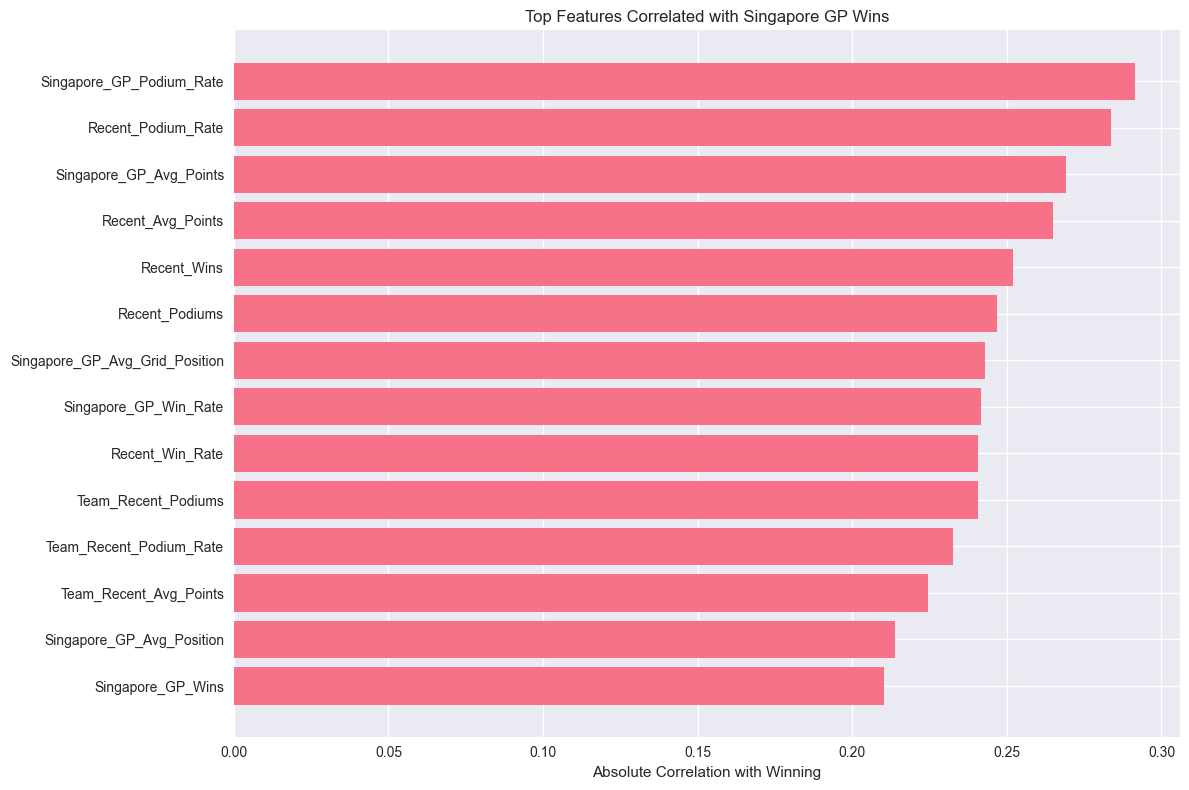


Singapore GP Winners by Year:
     Year Driver             Team
0    2008    ALO          Renault
25   2009    HAM          McLaren
2    2010    ALO          Ferrari
49   2011    VET         Red Bull
50   2012    VET         Red Bull
51   2013    VET         Red Bull
30   2014    HAM         Mercedes
53   2015    VET          Ferrari
23   2016    ROS         Mercedes
33   2017    HAM         Mercedes
34   2018    HAM         Mercedes
57   2019    VET          Ferrari
36   2020    HAM         Mercedes
292  2021    OCO           Alpine
191  2022    PER  Red Bull Racing
278  2023    SAI          Ferrari
332  2024    NOR          McLaren

Team Performance Summary:
                 IsWinner  IsPodium  IsTop10   Position
Team                                                   
Mercedes                5        10       22   7.433333
Ferrari                 4        12       27   6.647059
Red Bull                3        11       15   6.250000
McLaren                 2         7       22   9.1

In [18]:
# Feature analysis and visualization
print("=== FEATURE ANALYSIS ===")

# Analyze feature importance for predicting winners
feature_columns = [col for col in combined_features.columns if col not in ['Year', 'Driver', 'Team', 'Position', 'Points', 'GridPosition', 'IsWinner', 'IsPodium', 'IsTop10']]

# Only use numeric columns for correlation analysis to avoid ValueError
numeric_feature_columns = [col for col in feature_columns if pd.api.types.is_numeric_dtype(combined_features[col])]
if not numeric_feature_columns:
    print("No numeric features available for correlation analysis.")
else:
    correlation_with_winner = combined_features[numeric_feature_columns + ['IsWinner']].corr()['IsWinner'].abs().sort_values(ascending=False)
    print("\nTop 15 features correlated with winning:")
    print(correlation_with_winner.head(15))

# Visualize feature correlations
plt.figure(figsize=(12, 8))
top_features = correlation_with_winner.head(15).index[1:]  # Exclude IsWinner itself
correlation_values = correlation_with_winner.head(15).values[1:]

plt.barh(range(len(top_features)), correlation_values)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Absolute Correlation with Winning')
plt.title('Top Features Correlated with Singapore GP Wins')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Analyze winners by year
winners_by_year = combined_features[combined_features['IsWinner'] == 1][['Year', 'Driver', 'Team']].sort_values('Year')
print("\nSingapore GP Winners by Year:")
print(winners_by_year)

# Analyze team performance
team_performance = combined_features.groupby('Team').agg({
    'IsWinner': 'sum',
    'IsPodium': 'sum',
    'IsTop10': 'sum',
    'Position': 'mean'
}).sort_values('IsWinner', ascending=False)

print("\nTeam Performance Summary:")
print(team_performance.head(10))


In [19]:
## 8. Prepare Data for Modeling


In [20]:
# Prepare data for modeling
print("Preparing data for modeling...")

# Select features for modeling (exclude target variables and identifiers)
model_features = [col for col in combined_features.columns if col not in [
    'Year', 'Driver', 'Team', 'Position', 'Points', 'GridPosition', 
    'IsWinner', 'IsPodium', 'IsTop10', 'Weather_Condition', 'Data_Source'
]]

# Create feature matrix and target variables
X = combined_features[model_features]
y_winner = combined_features['IsWinner']
y_podium = combined_features['IsPodium']
y_top10 = combined_features['IsTop10']

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(model_features)}")

# Handle categorical variables
categorical_features = X.select_dtypes(include=['object']).columns
print(f"Categorical features: {list(categorical_features)}")

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Save label encoders for later use
joblib.dump(label_encoders, output_dir / 'label_encoders.pkl')

# Split data for training and testing
X_train, X_test, y_train_winner, y_test_winner = train_test_split(
    X, y_winner, test_size=0.2, random_state=42, stratify=y_winner
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for later use
joblib.dump(scaler, output_dir / 'feature_scaler.pkl')

print("Data preparation complete!")
print(f"Features saved: {output_dir / 'label_encoders.pkl'}")
print(f"Scaler saved: {output_dir / 'feature_scaler.pkl'}")

# Save prepared data
np.save(output_dir / 'X_train_scaled.npy', X_train_scaled)
np.save(output_dir / 'X_test_scaled.npy', X_test_scaled)
np.save(output_dir / 'y_train_winner.npy', y_train_winner)
np.save(output_dir / 'y_test_winner.npy', y_test_winner)

print("Prepared data saved!")


Preparing data for modeling...
Feature matrix shape: (358, 90)
Number of features: 90
Categorical features: ['Circuit_Name', 'Track_Type']
Training set shape: (286, 90)
Test set shape: (72, 90)
Data preparation complete!
Features saved: ..\data\features\label_encoders.pkl
Scaler saved: ..\data\features\feature_scaler.pkl
Prepared data saved!


In [21]:
# Train and evaluate multiple models
print("Training and evaluating models...")

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True)
}

# Train and evaluate models
model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train_winner)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_winner, y_pred)
    precision = precision_score(y_test_winner, y_pred, zero_division=0)
    recall = recall_score(y_test_winner, y_pred, zero_division=0)
    f1 = f1_score(y_test_winner, y_pred, zero_division=0)
    auc = roc_auc_score(y_test_winner, y_pred_proba) if y_pred_proba is not None else 0
    
    model_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }
    
    trained_models[name] = model
    
    print(f"{name} Results:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}")
    print(f"  AUC: {auc:.3f}")

# Create results dataframe
results_df = pd.DataFrame(model_results).T
print("\n=== MODEL COMPARISON ===")
print(results_df.round(3))

# Select best model based on F1 score
best_model_name = results_df['f1'].idxmax()
best_model = trained_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"F1 Score: {results_df.loc[best_model_name, 'f1']:.3f}")

# Save best model
joblib.dump(best_model, output_dir / 'best_model.pkl')
print(f"Best model saved to: {output_dir / 'best_model.pkl'}")


Training and evaluating models...

Training Random Forest...
Random Forest Results:
  Accuracy: 0.958
  Precision: 0.000
  Recall: 0.000
  F1-Score: 0.000
  AUC: 0.874

Training Gradient Boosting...
Gradient Boosting Results:
  Accuracy: 0.944
  Precision: 0.333
  Recall: 0.333
  F1-Score: 0.333
  AUC: 0.831

Training XGBoost...
XGBoost Results:
  Accuracy: 0.972
  Precision: 1.000
  Recall: 0.333
  F1-Score: 0.500
  AUC: 0.845

Training Logistic Regression...
Logistic Regression Results:
  Accuracy: 0.819
  Precision: 0.143
  Recall: 0.667
  F1-Score: 0.235
  AUC: 0.696

Training SVM...
SVM Results:
  Accuracy: 0.806
  Precision: 0.077
  Recall: 0.333
  F1-Score: 0.125
  AUC: 0.184

=== MODEL COMPARISON ===
                     accuracy  precision  recall     f1    auc
Random Forest           0.958      0.000   0.000  0.000  0.874
Gradient Boosting       0.944      0.333   0.333  0.333  0.831
XGBoost                 0.972      1.000   0.333  0.500  0.845
Logistic Regression     0.819 

Analyzing feature importance...

Top 20 Most Important Features:
                           feature  importance
15               Recent_Avg_Points    0.120925
5          Singapore_GP_Avg_Points    0.073246
3               Singapore_GP_Top10    0.056610
28       Team_Singapore_GP_Podiums    0.052943
35    Team_Singapore_GP_Top10_Rate    0.047907
40          Team_Recent_Avg_Points    0.040790
84           Average_Grid_Position    0.038017
36  Team_Singapore_GP_Position_Std    0.037713
23         Driver_Experience_Years    0.037194
10  Singapore_GP_Avg_Grid_Position    0.033430
20              Recent_Podium_Rate    0.032196
26         Team_Singapore_GP_Count    0.031658
7            Singapore_GP_Win_Rate    0.031530
6       Singapore_GP_Best_Position    0.025953
38   Team_Singapore_GP_Finish_Rate    0.024669
82                       DNF_Count    0.022412
18                    Recent_Top10    0.021899
86                Position_Changes    0.020453
39        Team_Recent_Avg_Position    0.01

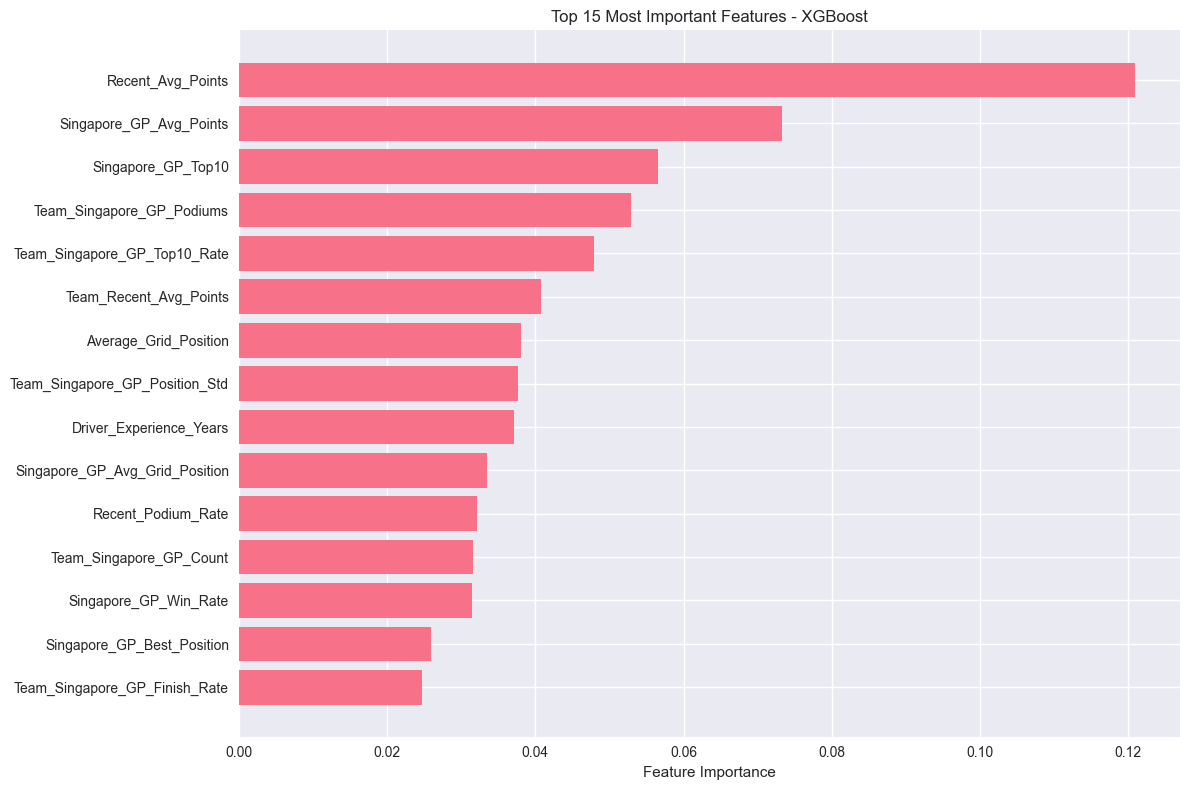

Feature importance saved to: ..\data\features\feature_importance.csv


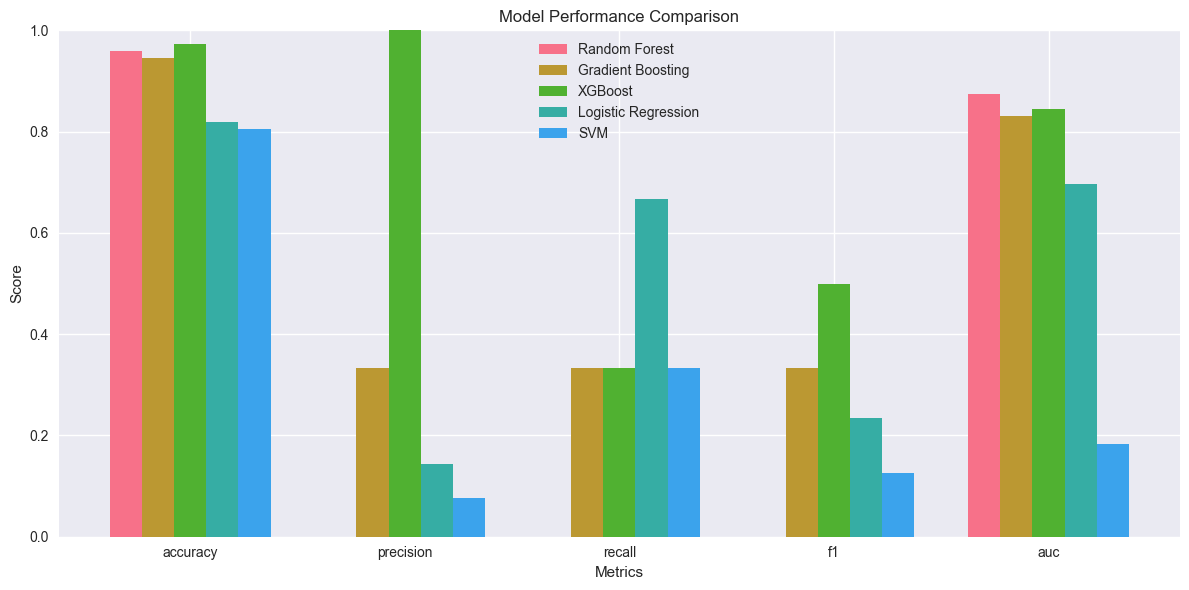

Model training and evaluation complete!


In [22]:
# Feature importance analysis
print("Analyzing feature importance...")

# Get feature importance from best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': model_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Most Important Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Save feature importance
    feature_importance.to_csv(output_dir / 'feature_importance.csv', index=False)
    print(f"Feature importance saved to: {output_dir / 'feature_importance.csv'}")

# Model performance visualization
plt.figure(figsize=(12, 6))

# Plot model comparison
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
x = np.arange(len(metrics))
width = 0.15

for i, (model_name, results) in enumerate(model_results.items()):
    values = [results[metric] for metric in metrics]
    plt.bar(x + i * width, values, width, label=model_name)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width * 2, metrics)
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("Model training and evaluation complete!")


In [24]:
# Create prediction pipeline for 2025 Singapore GP
print("Creating prediction pipeline for 2025 Singapore GP...")

def create_2025_prediction_data():
    """Create prediction data for 2025 Singapore GP"""
    
    # 2025 F1 drivers and teams (current season data)
    drivers_2025 = [
        {'Driver': 'VER', 'Team': 'Red Bull Racing', 'FullName': 'Max Verstappen'},
        {'Driver': 'PER', 'Team': 'Red Bull Racing', 'FullName': 'Sergio Perez'},
        {'Driver': 'LEC', 'Team': 'Ferrari', 'FullName': 'Charles Leclerc'},
        {'Driver': 'SAI', 'Team': 'Ferrari', 'FullName': 'Carlos Sainz'},
        {'Driver': 'HAM', 'Team': 'Mercedes', 'FullName': 'Lewis Hamilton'},
        {'Driver': 'RUS', 'Team': 'Mercedes', 'FullName': 'George Russell'},
        {'Driver': 'NOR', 'Team': 'McLaren', 'FullName': 'Lando Norris'},
        {'Driver': 'PIA', 'Team': 'McLaren', 'FullName': 'Oscar Piastri'},
        {'Driver': 'ALO', 'Team': 'Aston Martin', 'FullName': 'Fernando Alonso'},
        {'Driver': 'STR', 'Team': 'Aston Martin', 'FullName': 'Lance Stroll'},
        {'Driver': 'OCO', 'Team': 'Alpine', 'FullName': 'Esteban Ocon'},
        {'Driver': 'GAS', 'Team': 'Alpine', 'FullName': 'Pierre Gasly'},
        {'Driver': 'BOT', 'Team': 'Sauber', 'FullName': 'Valtteri Bottas'},
        {'Driver': 'ZHO', 'Team': 'Sauber', 'FullName': 'Zhou Guanyu'},
        {'Driver': 'MAG', 'Team': 'Haas', 'FullName': 'Kevin Magnussen'},
        {'Driver': 'HUL', 'Team': 'Haas', 'FullName': 'Nico Hulkenberg'},
        {'Driver': 'ALB', 'Team': 'Williams', 'FullName': 'Alexander Albon'},
        {'Driver': 'SAR', 'Team': 'Williams', 'FullName': 'Logan Sargeant'},
        {'Driver': 'RIC', 'Team': 'RB', 'FullName': 'Daniel Ricciardo'},
        {'Driver': 'TSU', 'Team': 'RB', 'FullName': 'Yuki Tsunoda'}
    ]
    
    # Create prediction dataframe
    prediction_data = []
    
    for driver_info in drivers_2025:
        driver = driver_info['Driver']
        team = driver_info['Team']
        
        # Get historical data for this driver
        driver_historical = combined_features[
            (combined_features['Driver'] == driver) & 
            (combined_features['Year'] < 2025)
        ]
        
        # Get team historical data
        team_historical = combined_features[
            (combined_features['Team'] == team) & 
            (combined_features['Year'] < 2025)
        ]
        
        # Create features for 2025 prediction
        features_2025 = {
            'Year': 2025,
            'Driver': driver,
            'Team': team,
            'FullName': driver_info['FullName']
        }
        
        # Driver features (use most recent data or averages)
        if len(driver_historical) > 0:
            recent_driver = driver_historical.iloc[-1]  # Most recent year
            
            # Singapore GP specific features
            features_2025.update({
                'Singapore_GP_Count': recent_driver['Singapore_GP_Count'] + 1,
                'Singapore_GP_Wins': recent_driver['Singapore_GP_Wins'],
                'Singapore_GP_Podiums': recent_driver['Singapore_GP_Podiums'],
                'Singapore_GP_Top10': recent_driver['Singapore_GP_Top10'],
                'Singapore_GP_Avg_Position': recent_driver['Singapore_GP_Avg_Position'],
                'Singapore_GP_Avg_Points': recent_driver['Singapore_GP_Avg_Points'],
                'Singapore_GP_Best_Position': recent_driver['Singapore_GP_Best_Position'],
                'Singapore_GP_Win_Rate': recent_driver['Singapore_GP_Win_Rate'],
                'Singapore_GP_Podium_Rate': recent_driver['Singapore_GP_Podium_Rate'],
                'Singapore_GP_Top10_Rate': recent_driver['Singapore_GP_Top10_Rate'],
                'Singapore_GP_Avg_Grid_Position': recent_driver['Singapore_GP_Avg_Grid_Position'],
                'Singapore_GP_Grid_Improvement': recent_driver['Singapore_GP_Grid_Improvement'],
                'Singapore_GP_Position_Std': recent_driver['Singapore_GP_Position_Std'],
                'Singapore_GP_Consistency': recent_driver['Singapore_GP_Consistency'],
                
                # Recent form (use 2024 data)
                'Recent_Avg_Position': recent_driver['Recent_Avg_Position'],
                'Recent_Avg_Points': recent_driver['Recent_Avg_Points'],
                'Recent_Wins': recent_driver['Recent_Wins'],
                'Recent_Podiums': recent_driver['Recent_Podiums'],
                'Recent_Top10': recent_driver['Recent_Top10'],
                'Recent_Win_Rate': recent_driver['Recent_Win_Rate'],
                'Recent_Podium_Rate': recent_driver['Recent_Podium_Rate'],
                'Recent_Top10_Rate': recent_driver['Recent_Top10_Rate'],
                'Recent_Consistency': recent_driver['Recent_Consistency'],
                
                # Experience
                'Driver_Experience_Years': 2025 - 2008,
                'Is_Rookie': 0,
                'Is_Veteran': 1 if recent_driver['Singapore_GP_Count'] >= 5 else 0
            })
        else:
            # New driver - use default values
            features_2025.update({
                'Singapore_GP_Count': 0,
                'Singapore_GP_Wins': 0,
                'Singapore_GP_Podiums': 0,
                'Singapore_GP_Top10': 0,
                'Singapore_GP_Avg_Position': 20,
                'Singapore_GP_Avg_Points': 0,
                'Singapore_GP_Best_Position': 20,
                'Singapore_GP_Win_Rate': 0,
                'Singapore_GP_Podium_Rate': 0,
                'Singapore_GP_Top10_Rate': 0,
                'Singapore_GP_Avg_Grid_Position': 20,
                'Singapore_GP_Grid_Improvement': 0,
                'Singapore_GP_Position_Std': 0,
                'Singapore_GP_Consistency': 0.5,
                'Recent_Avg_Position': 20,
                'Recent_Avg_Points': 0,
                'Recent_Wins': 0,
                'Recent_Podiums': 0,
                'Recent_Top10': 0,
                'Recent_Win_Rate': 0,
                'Recent_Podium_Rate': 0,
                'Recent_Top10_Rate': 0,
                'Recent_Consistency': 0.5,
                'Driver_Experience_Years': 2025 - 2008,
                'Is_Rookie': 1,
                'Is_Veteran': 0
            })
        
        # Team features
        if len(team_historical) > 0:
            recent_team = team_historical.iloc[-1]
            
            features_2025.update({
                'Team_Singapore_GP_Count': recent_team['Team_Singapore_GP_Count'] + 1,
                'Team_Singapore_GP_Wins': recent_team['Team_Singapore_GP_Wins'],
                'Team_Singapore_GP_Podiums': recent_team['Team_Singapore_GP_Podiums'],
                'Team_Singapore_GP_Top10': recent_team['Team_Singapore_GP_Top10'],
                'Team_Singapore_GP_Avg_Position': recent_team['Team_Singapore_GP_Avg_Position'],
                'Team_Singapore_GP_Avg_Points': recent_team['Team_Singapore_GP_Avg_Points'],
                'Team_Singapore_GP_Best_Position': recent_team['Team_Singapore_GP_Best_Position'],
                'Team_Singapore_GP_Win_Rate': recent_team['Team_Singapore_GP_Win_Rate'],
                'Team_Singapore_GP_Podium_Rate': recent_team['Team_Singapore_GP_Podium_Rate'],
                'Team_Singapore_GP_Top10_Rate': recent_team['Team_Singapore_GP_Top10_Rate'],
                'Team_Singapore_GP_Position_Std': recent_team['Team_Singapore_GP_Position_Std'],
                'Team_Singapore_GP_Consistency': recent_team['Team_Singapore_GP_Consistency'],
                'Team_Singapore_GP_Finish_Rate': recent_team['Team_Singapore_GP_Finish_Rate'],
                'Team_Recent_Avg_Position': recent_team['Team_Recent_Avg_Position'],
                'Team_Recent_Avg_Points': recent_team['Team_Recent_Avg_Points'],
                'Team_Recent_Wins': recent_team['Team_Recent_Wins'],
                'Team_Recent_Podiums': recent_team['Team_Recent_Podiums'],
                'Team_Recent_Top10': recent_team['Team_Recent_Top10'],
                'Team_Recent_Win_Rate': recent_team['Team_Recent_Win_Rate'],
                'Team_Recent_Podium_Rate': recent_team['Team_Recent_Podium_Rate'],
                'Team_Recent_Top10_Rate': recent_team['Team_Recent_Top10_Rate'],
                'Team_Recent_Consistency': recent_team['Team_Recent_Consistency'],
                'Team_Experience_Years': 2025 - 2008,
                'Is_New_Team': 0,
                'Is_Established_Team': 1 if recent_team['Team_Singapore_GP_Count'] >= 5 else 0
            })
        else:
            # New team
            features_2025.update({
                'Team_Singapore_GP_Count': 0,
                'Team_Singapore_GP_Wins': 0,
                'Team_Singapore_GP_Podiums': 0,
                'Team_Singapore_GP_Top10': 0,
                'Team_Singapore_GP_Avg_Position': 20,
                'Team_Singapore_GP_Avg_Points': 0,
                'Team_Singapore_GP_Best_Position': 20,
                'Team_Singapore_GP_Win_Rate': 0,
                'Team_Singapore_GP_Podium_Rate': 0,
                'Team_Singapore_GP_Top10_Rate': 0,
                'Team_Singapore_GP_Position_Std': 0,
                'Team_Singapore_GP_Consistency': 0.5,
                'Team_Singapore_GP_Finish_Rate': 0.8,
                'Team_Recent_Avg_Position': 20,
                'Team_Recent_Avg_Points': 0,
                'Team_Recent_Wins': 0,
                'Team_Recent_Podiums': 0,
                'Team_Recent_Top10': 0,
                'Team_Recent_Win_Rate': 0,
                'Team_Recent_Podium_Rate': 0,
                'Team_Recent_Top10_Rate': 0,
                'Team_Recent_Consistency': 0.5,
                'Team_Experience_Years': 2025 - 2008,
                'Is_New_Team': 1,
                'Is_Established_Team': 0
            })
        
        # Weather features (use average Singapore weather)
        features_2025.update({
            'Temperature_Avg_C': 28.5,
            'Humidity_Percent': 80.0,
            'Precipitation_mm': 5.0,
            'Wind_Speed_kmh': 8.0,
            'Weather_Condition': 'Clear',
            'Data_Source': 'Prediction',
            'Is_Hot': 0,
            'Is_Cool': 0,
            'Is_Humid': 1,
            'Is_Dry': 0,
            'Is_Rainy': 0,
            'Is_Clear': 1,
            'Is_Windy': 0,
            'Weather_Severity': 1,
            'Temperature_Deviation': 0.0,
            'Humidity_Deviation': 0.0
        })
        
        # Track features (Singapore circuit characteristics)
        features_2025.update({
            'Circuit_Name': 'Marina Bay Street Circuit',
            'Circuit_Length_km': 5.063,
            'Turns': 23,
            'Lap_Record_Seconds': 95.0,
            'Overtaking_Difficulty': 8,
            'Tire_Degradation': 7,
            'Track_Temperature_Range': 5,
            'Safety_Car_Probability': 0.6,
            'DNF_Rate': 0.15,
            'Pit_Stop_Strategy': 2,
            'Track_Type': 'Street Circuit',
            'Is_Night_Race': 1,
            'Is_Street_Circuit': 1,
            'Is_High_Downforce': 1,
            'Is_Tight_Circuit': 1,
            'Total_Finishers': 20,
            'Total_Starters': 20,
            'DNF_Count': 3,
            'Safety_Car_Deployed': 1,
            'Average_Grid_Position': 10.5,
            'Grid_Position_Std': 5.0,
            'Position_Changes': 2.0,
            'High_Attrition_Race': 0,
            'Close_Competition': 1,
            'Grid_Spread': 20
        })
        
        prediction_data.append(features_2025)
    
    return pd.DataFrame(prediction_data)

# Create 2025 prediction data
prediction_2025 = create_2025_prediction_data()

print(f"Created prediction data for {len(prediction_2025)} drivers")
print("2025 Singapore GP Prediction Data:")
print(prediction_2025[['Driver', 'Team', 'FullName', 'Singapore_GP_Wins', 'Singapore_GP_Podiums']].head(20))


Creating prediction pipeline for 2025 Singapore GP...
Created prediction data for 20 drivers
2025 Singapore GP Prediction Data:
   Driver             Team          FullName  Singapore_GP_Wins  \
0     VER  Red Bull Racing    Max Verstappen                  0   
1     PER  Red Bull Racing      Sergio Perez                  1   
2     LEC          Ferrari   Charles Leclerc                  0   
3     SAI          Ferrari      Carlos Sainz                  1   
4     HAM         Mercedes    Lewis Hamilton                  5   
5     RUS         Mercedes    George Russell                  0   
6     NOR          McLaren      Lando Norris                  0   
7     PIA          McLaren     Oscar Piastri                  0   
8     ALO     Aston Martin   Fernando Alonso                  2   
9     STR     Aston Martin      Lance Stroll                  0   
10    OCO           Alpine      Esteban Ocon                  1   
11    GAS           Alpine      Pierre Gasly                  0   
1

In [25]:
# Make predictions for 2025 Singapore GP
print("Making predictions for 2025 Singapore GP...")

# Prepare prediction data (same features as training data)
X_pred = prediction_2025[model_features].copy()

# Handle categorical variables using saved encoders
for col in categorical_features:
    if col in X_pred.columns:
        le = label_encoders[col]
        # Handle unseen categories
        X_pred[col] = X_pred[col].astype(str)
        X_pred[col] = X_pred[col].apply(lambda x: x if x in le.classes_ else 'Unknown')
        
        # Add 'Unknown' to encoder if not present
        if 'Unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'Unknown')
        
        X_pred[col] = le.transform(X_pred[col])

# Scale features using saved scaler
X_pred_scaled = scaler.transform(X_pred)

# Make predictions
win_probabilities = best_model.predict_proba(X_pred_scaled)[:, 1]
predictions = best_model.predict(X_pred_scaled)

# Create results dataframe
results_2025 = prediction_2025[['Driver', 'Team', 'FullName']].copy()
results_2025['Win_Probability'] = win_probabilities
results_2025['Predicted_Winner'] = predictions

# Sort by win probability
results_2025 = results_2025.sort_values('Win_Probability', ascending=False)

print("\n🏆 2025 SINGAPORE GP PREDICTIONS")
print("="*50)
print("Top 10 Most Likely Winners:")
print(results_2025.head(10)[['Driver', 'FullName', 'Team', 'Win_Probability']])

# Show podium predictions
print("\n🥇 PODIUM PREDICTIONS:")
print("1st Place:", results_2025.iloc[0]['FullName'], f"({results_2025.iloc[0]['Win_Probability']:.1%})")
print("2nd Place:", results_2025.iloc[1]['FullName'], f"({results_2025.iloc[1]['Win_Probability']:.1%})")
print("3rd Place:", results_2025.iloc[2]['FullName'], f"({results_2025.iloc[2]['Win_Probability']:.1%})")

# Team analysis
print("\n🏭 TEAM ANALYSIS:")
team_predictions = results_2025.groupby('Team').agg({
    'Win_Probability': 'sum',
    'Driver': 'count'
}).sort_values('Win_Probability', ascending=False)
team_predictions.columns = ['Total_Win_Probability', 'Drivers']
print(team_predictions.head())

# Save predictions
results_2025.to_csv(output_dir / 'singapore_gp_2025_predictions.csv', index=False)
print(f"\nPredictions saved to: {output_dir / 'singapore_gp_2025_predictions.csv'}")

# Create prediction summary
prediction_summary = {
    'Model': best_model_name,
    'F1_Score': results_df.loc[best_model_name, 'f1'],
    'Predicted_Winner': results_2025.iloc[0]['FullName'],
    'Winner_Probability': results_2025.iloc[0]['Win_Probability'],
    'Top_Team': team_predictions.index[0],
    'Total_Drivers': len(results_2025),
    'Prediction_Date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save prediction summary
pd.DataFrame([prediction_summary]).to_csv(output_dir / 'prediction_summary.csv', index=False)
print(f"Prediction summary saved to: {output_dir / 'prediction_summary.csv'}")

print("\n✅ Feature engineering and prediction pipeline complete!")


Making predictions for 2025 Singapore GP...

🏆 2025 SINGAPORE GP PREDICTIONS
Top 10 Most Likely Winners:
   Driver         FullName             Team  Win_Probability
6     NOR     Lando Norris          McLaren         0.817734
3     SAI     Carlos Sainz          Ferrari         0.157249
7     PIA    Oscar Piastri          McLaren         0.071638
2     LEC  Charles Leclerc          Ferrari         0.032079
15    HUL  Nico Hulkenberg             Haas         0.031745
0     VER   Max Verstappen  Red Bull Racing         0.018642
14    MAG  Kevin Magnussen             Haas         0.017416
1     PER     Sergio Perez  Red Bull Racing         0.014058
4     HAM   Lewis Hamilton         Mercedes         0.012507
8     ALO  Fernando Alonso     Aston Martin         0.005353

🥇 PODIUM PREDICTIONS:
1st Place: Lando Norris (81.8%)
2nd Place: Carlos Sainz (15.7%)
3rd Place: Oscar Piastri (7.2%)

🏭 TEAM ANALYSIS:
                 Total_Win_Probability  Drivers
Team                                   